# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

In [35]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily
import datetime
import seaborn as sns
import torch
import torchtime.data

## 1. Data Exploration

In [26]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/Visitor_Forecast.xlsx")
visitor_data.iloc[:5, :]

,date,09:30:00,10:45:00,13:45:00,16:15:00,17:45:00,18:00:00,18:30:00,18:45:00
0,2023-04-17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2023-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-19,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,2023-04-20,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0
4,2023-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      171 non-null    datetime64[ns]
 1   09:30:00  142 non-null    float64       
 2   10:45:00  151 non-null    float64       
 3   13:45:00  152 non-null    float64       
 4   16:15:00  152 non-null    float64       
 5   17:45:00  122 non-null    float64       
 6   18:00:00  119 non-null    float64       
 7   18:30:00  126 non-null    float64       
 8   18:45:00  111 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 12.2 KB


In [ ]:
visitor_data.columns = [str(column) for column in visitor_data.columns]
visitor_data.columns

Index(['date', '09:30:00', '10:45:00', '13:45:00', '16:15:00', '17:45:00',
       '18:00:00', '18:30:00', '18:45:00'],
      dtype='object')

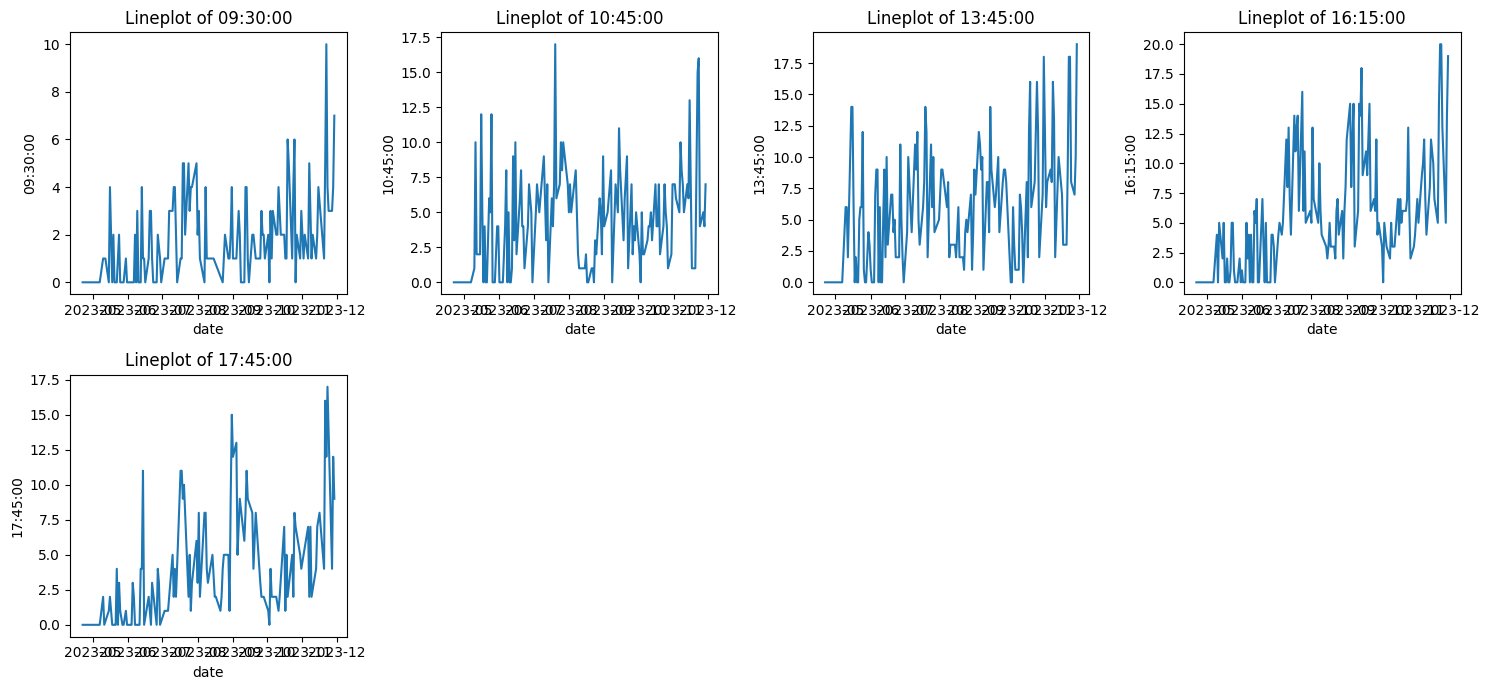

In [ ]:
# Visualize the times
plt.figure(figsize=(15, 7))

category = ['09:30:00', '10:45:00', '13:45:00', '16:15:00', '17:45:00']
total_subplots = len(category)

rows = (total_subplots // 4) + 1
cols = min(total_subplots, 4)

for i, col in enumerate(category):
    plt.subplot(rows, cols, i + 1)
    sns.lineplot(y=visitor_data[col], x=visitor_data["date"])
    plt.title(f'Lineplot of {col}')

plt.tight_layout()  # Adjusts the plots to fit into the figure area.
plt.show()

# Becasue of the missing values, we have a lot of gaps/random zeros

## 2. Data Preprocessing

- Man könnte alle Daten erfassen (auch wenn nicht in der Statistik) damit dem Model kalr wird, dass am Wochende bzw. Feiertagen keiner kommt
- Missing Values mit 
    - Median
    - k-Nearest Neighbors

- Prüfungsphase
- Weekend & Holiday



- Neue datenstruktur:
    - Firaz: ab August
    - Patryk: älter als August

In [ ]:
# add column "weekday"
# fill "weekday" with weekdays in relation to the date
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"] 
visitor_data["weekday"] = [days[weekday] for weekday in visitor_data["date"].dt.dayofweek]
visitor_data

,date,09:30:00,10:45:00,13:45:00,16:15:00,17:45:00,18:00:00,18:30:00,18:45:00,weekday
0,2023-04-17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,monday
1,2023-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tuesday
2,2023-04-19,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,wednesday
3,2023-04-20,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,thursday
4,2023-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,friday
...,...,...,...,...,...,...,...,...,...,...
166,2023-11-23,4.0,16.0,18.0,20.0,17.0,NaN,10.0,NaN,thursday
167,2023-11-24,3.0,4.0,8.0,13.0,NaN,NaN,NaN,NaN,friday
168,2023-11-27,3.0,5.0,7.0,5.0,4.0,NaN,2.0,NaN,monday
169,2023-11-28,4.0,4.0,10.0,14.0,12.0,NaN,11.0,NaN,tuesday


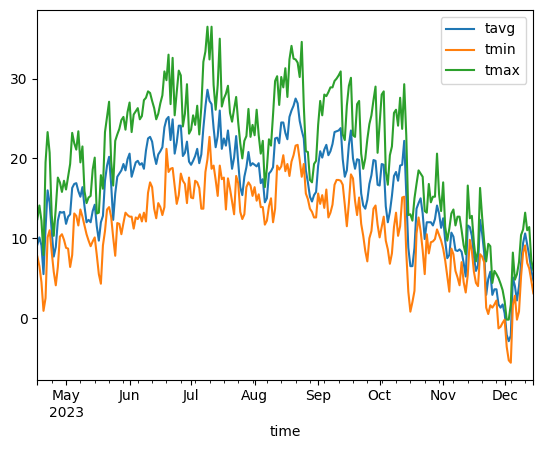

In [ ]:
# Get the weather data until today
today_year = int(str(datetime.today())[0:4])
today_month = int(str(datetime.today())[5:7])
today_day = int(str(datetime.today())[8:10])

# get weather data thorught the date
start = datetime(2023, 4, 17)
end = datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

weather_data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [ ]:
# merge data frames
joined_df = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

joined_df

,date,09:30:00,10:45:00,13:45:00,16:15:00,17:45:00,18:00:00,18:30:00,18:45:00,weekday,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2023-04-17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,monday,9.2,7.7,12.4,0.1,0.0,353.0,10.1,28.8,1022.0,34.0
1,2023-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tuesday,10.1,6.5,14.1,0.0,0.0,46.0,11.2,36.7,1021.7,6.0
2,2023-04-19,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,wednesday,9.1,4.5,12.2,0.1,0.0,41.0,7.9,24.5,1020.4,86.0
3,2023-04-20,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,thursday,5.5,0.9,7.9,1.3,0.0,71.0,7.6,33.5,1014.8,182.0
4,2023-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,friday,11.2,2.5,19.5,0.2,0.0,110.0,7.6,36.0,1011.7,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2023-11-23,4.0,16.0,18.0,20.0,17.0,NaN,10.0,NaN,thursday,4.9,0.5,9.3,4.4,0.0,211.0,9.4,41.4,1025.6,74.0
167,2023-11-24,3.0,4.0,8.0,13.0,NaN,NaN,NaN,NaN,friday,5.8,1.6,9.0,5.3,0.0,277.0,21.6,63.7,1011.0,11.0
168,2023-11-27,3.0,5.0,7.0,5.0,4.0,NaN,2.0,NaN,monday,3.6,2.2,5.5,6.3,0.0,199.0,9.4,30.6,1005.0,0.0
169,2023-11-28,4.0,4.0,10.0,14.0,12.0,NaN,11.0,NaN,tuesday,1.7,-1.3,5.0,1.8,0.0,282.0,16.9,49.7,1001.6,0.0


## 3. Build Model

In [ ]:
print(visitor_data.shape)

(171, 10)
